In [1]:
%matplotlib notebook
import numpy as np
from numpy import array, dot, sin, cos, pi, exp
from scipy.linalg import solve_banded
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
np.set_printoptions(
    precision=4, suppress=True)

<h1 align='center'>Методы решения начально-краевых задач <br>для параболических уравнений</h1>

## План

1. Постановка задачи
2. Точное решение методом Фурье
3. Сеточные методы
    - Идеи и основные понятия
    - Аппроксимация уравнения с помощью разностных схем
        1. Явная схема
        2. Неявная схема
        3. Схема Кранка-Николсон
        4. Немного о весовых схемах 
    - Аппроксимация краевых условий 2-го и 3-го рода

## Постановка задачи 

Рассмотрим линейное уравнение распространения тепла на прямой с заданой начальной температурой стержня и температурным режимом на его концах:

$$ \frac{\partial u}{\partial t} = a^2 \frac{\partial^2 u}{\partial x^2} + f(x, t),
   \text{ }x\in(0; l),\text{ }t > 0,\\ u\rvert_{t=0}=\varphi(x),\\
   u\rvert_{x=0}=\mu_1(t),\text{ }u\rvert_{x=l}=\mu_2(t).$$
   
В дальнейшем мы рассмотрим также и численные методы решения задачи при краевых условиях другого вида.

In [2]:
l = 1
a = 1 / (2*pi)
f = lambda x, t: 3 * sin(2*t) * sin(pi*x)
phi = lambda x: 2*sin(4*pi*x) - 3 - x
mu1 = lambda t: -3
mu2 = lambda t: -4

In [3]:
# контрольный пример
# l = 1
# a = 1 / (6*pi)
# f = lambda x, t: -2*sin(t)*sin(3*pi*x)
# phi = lambda x: 3*sin(2*pi*x) + 4 - 5*x
# mu1 = lambda t: 4
# mu2 = lambda t: -1

## Точное решение методом Фурье 

Первое, что стоит сделать $-$ свести задачу с неоднородными краевыми условиями к задаче с однородными. Делается это заменой 

$$ u(x, t) = v(x, t) + w(x, t), $$

где $v=v(x, t)$ $-$ новая неизвестная функция, а $w(x, t) = \mu_1(t) + \frac{x}{l}\left(\mu_2(t)-\mu_1(t)\right)$.

Итак, пусть перед нами стоит исходная задача, но теперь уже отосительно функции $v(x, t)$ и краевые условия однородны. В общем виде решение такой задачи с помощью метода Фурье представляется так:

$$ v(x, t)=
\sum\limits_{n=1}^{\infty}\varphi_n e^{-(\frac{\pi n}{l})^2 a^2 t} \sin{\frac{\pi n}{l}x} + 
\sum\limits_{n=1}^{\infty}\left[ \int\limits_0^t {f_n(\tau)e^{-(\frac{\pi n}{l})^2 a^2 (t-\tau)}d\tau} \right]\sin{\frac{\pi n}{l}x},$$

где 

$$f_n(t)=\frac{2}{l}\int\limits_0^l f(x, t)\sin{\frac{\pi n}{l}x}dx,\text{ }
  \varphi_n=\frac{2}{l}\int\limits_0^l \varphi(x)\sin{\frac{\pi n}{l}x}dx.$$
  
Пользоваться этой формулой, однако, крайне неудобно (хотя в нашем случае, когда заданные функции $f$ и $\varphi$ содержат в себе синусоиды, многие элементы $f_n$ и $\varphi_n$ обнулятся), поэтому решим нашу конкретную задачу им поэтапно.

<IPython.core.display.Javascript object>


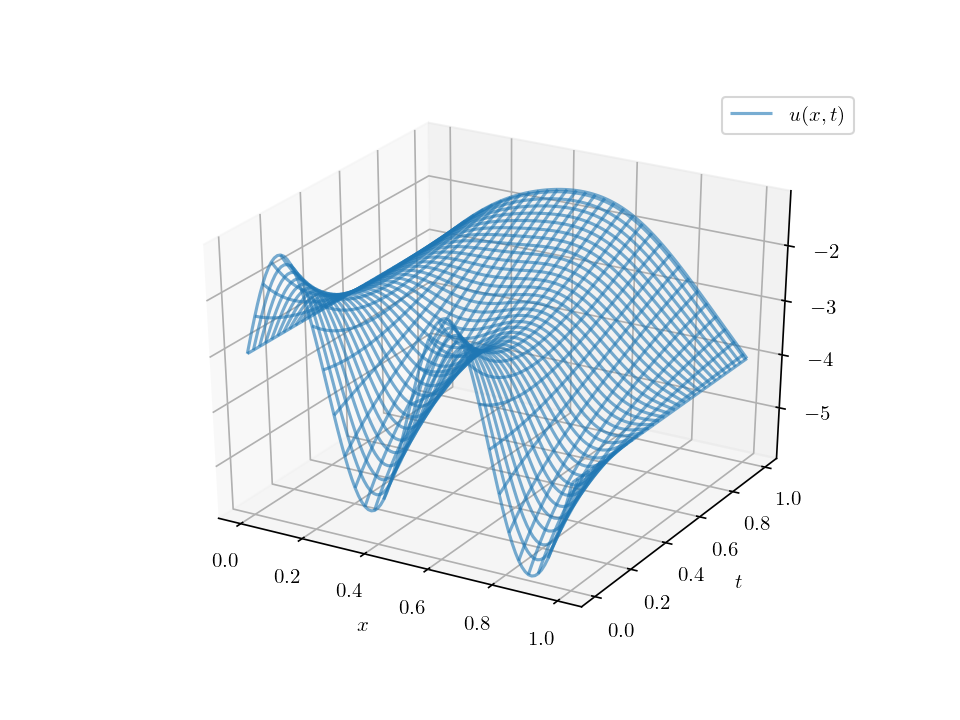

In [3]:
u_true = lambda x, t: 1/65*(96*exp(-t/4)+12*sin(2*t)-96*cos(2*t))*sin(pi*x) + 2*exp(-4*t)*sin(4*pi*x) - 3 - x
x_dense = np.linspace(0, l, 101)
t_dense = np.linspace(0, 1, 101)
xx_dense, tt_dense = np.meshgrid(x_dense, t_dense)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot_wireframe(xx_dense, tt_dense, u_true(xx_dense, tt_dense), alpha=0.6, label='$u(x, t)$')
ax1.set_xlabel('$x$'); ax1.set_ylabel('$t$')
ax1.legend();

In [4]:
def plot_solution(uu, xx, tt, u_true, method_name):
    global xx_dense, tt_dense
    h = xx[0, 1] - xx[0, 0]
    tau = tt[1, 0] - tt[0, 0]
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_wireframe(xx_dense, tt_dense, u_true(xx_dense, tt_dense), alpha=0.6, label='$u(x, t)$')
    ax1.plot_wireframe(xx, tt, uu, alpha=0.75, color='r',
                       label='$\hat{u}(x, t), h=%.2f, \\tau=%.2f$' % (h, tau))
    ax1.scatter(xx, tt, uu, alpha=0.75, s=10, c='r')
    ax1.set_title('Solution with "%s" method' % method_name)
    
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_wireframe(xx, tt, np.abs(uu - u_true(xx, tt)), 
                       label='$|\hat{u} - u|, h=%.2f, \\tau=%.2f$' % (h, tau))
    ax2.set_title('Error of solution')
    
    for ax in fig.get_axes():
        ax.set_xlabel('$x$'); ax.set_ylabel('$t$')
        ax.legend(loc=3);
        
    fig.tight_layout()
    return fig

## Сеточные методы 

### Идеи и основные понятия

Как и для эллиптических уравнений, сеточные методы заключаются в дискретизации области определения, в которой ищется решение, путём введения конечной сетки по всем переменным, а также замены дифференциальных выражений, присутствующих в уравнении, определёнными разностными схемами относительно значений искомой функции в узлах сетки. 

Будем рассматривать конечную прямоугольную область. По иксу (пространственной переменной) всё уже хорошо. Временная переменная же может принимать любые положительные значения, что нас не очень устраивает, поэтому мы ограничиваем их каким-то моментом времени $T$ (есть способы работать и с бесконечно большими моментами времени, но не будем об этом). В итоге получили прямоугольную область $\overline{\Omega}=[0; l]\times[0; T]$. 

Сеткой $\overline{\Omega}_{h}^{\tau}$ будем называть точки пересечения вертикальных (пространственных, $x=x_i=ih$, где $h=l / n$) и горизонтальных (временных, $t=t_k = k\tau$, где $\tau = T/m$) прямых. Узлы, лежащие на одной вертикальной прямой $t=t_k$ называются $k$-м временным слоем.

Будем использовать обозначение $u_i^k := u(x_i, t_k)$, $\mu_j(t_k):=\mu_j^k$, $\varphi_j(x_i):=\varphi_i$.

Величины $h$ и $\tau$ называются шагами сетки. Правильный выбор их значений достаточно важен для хорошей работы метода. От их величин или даже соотношения может зависить сходимость и устойчивость методов. Вообще, в отличии от стационарных эллиптических уравнений, мы будем искать порядок аппроксимации уравнения разностной схемой как величину, одновременно зависящую и от шага по пространственной переменной, и от шага по временной, в виде $O(h^p + \tau^q), h\to0, \tau\to0$.



_Тут ещё теоретических сведений об устойчивости, условной устойчивости, явности и неявности, количестве слоёв, более формально описать тему с порядком аппроксимации, рассказать, как он находится и как строятся коэффициенты схемы_

_Что-то про концы отрезка, на которых пользуемся краевыми условиями_.


Обозначим $$\gamma=\frac{a^2\tau}{h^2}.$$

In [5]:
h, tau, T = 0.1, 0.1, 1 # initially, h = 0.25
gamma = a**2 * tau / h**2
print('gamma = %.4f' %gamma)

gamma = 0.2533


In [6]:
# подготовим все нужные структурные элементы
n, m = int(1/h),  int(1/tau)
x = np.linspace(0, 1, n+1)
t = np.linspace(0, 1, m+1)
xx, tt = np.meshgrid(x, t)
ff = f(xx, tt)
uu = np.zeros_like(xx)

In [7]:
# первый временной слой задаём из начальных условий 
uu[0] = phi(x)
# на краях отрезка зададим температурный режим
uu[:,  0] = mu1(t)
uu[:, -1] = mu2(t)

### Аппроксимация уравнения с помощью разностных схем

#### A. Явная схема

Шаблон:

Производные аппроксимируются достаточно естественными разностными аналогами:

$$ \begin{align}
   &\frac{\partial u}{\partial t}\Bigg\rvert_{(x_i, t_k)}=\frac{u_i^{k+1}-u_i^k}{\tau}+O(\tau),\\
   &\frac{\partial^2 x}{\partial x^2}\Bigg\rvert_{(x_i ,t_k)}=\frac{u_{i-1}^k - 2u_i^k + u_{i+1}^k}{h^2}+O(h^2).
   \end{align}$$
   
Подставляя в исходное уравнение, можем получить такое выражение для значения функции на узлах следующего слоя через значения на текущем слое:

$$u_0^{k+1} = \mu_1^{k+1},\\
u_i^{k+1} = \gamma u_{i-1}^k + (1-2\gamma)u_i^k + \gamma u_{i+1}^k + \tau f_i^k,\text{ }i\in\{1, 2, ..., n-1\},\\
u_n^{k+1} = \mu_2^{k+1}.$$

Эту формулу мы постепенно применяем на всех слоях, пока не построим значения функции во всех узлах сетки. Помним, что нулевой слой нам уже задан, как и граничные условия.

Схема имеет порядок сходимости $O(h^2 + \tau)$ и является условно устойчивой (устойчива при $\gamma=\frac{a^2\tau}{h^2}\leq\frac{1}{2}$).

In [8]:
if gamma <= 0.5:
    print("Схема устойчива.")
else: 
    print("Схема неустойчива. Рекомендуется уменьшить шаг сетки по времени.")

Схема устойчива.


In [10]:
uu_expl = uu.copy()

for k in range(m):
    uk, fk = uu_expl[k], ff[k]
    uu_expl[k+1, 1:-1] = gamma*uk[:-2] + (1-2*gamma)*uk[1:-1] + gamma*uk[2:] + tau*fk[1:-1]
    
#uu_expl[::-1]

<IPython.core.display.Javascript object>


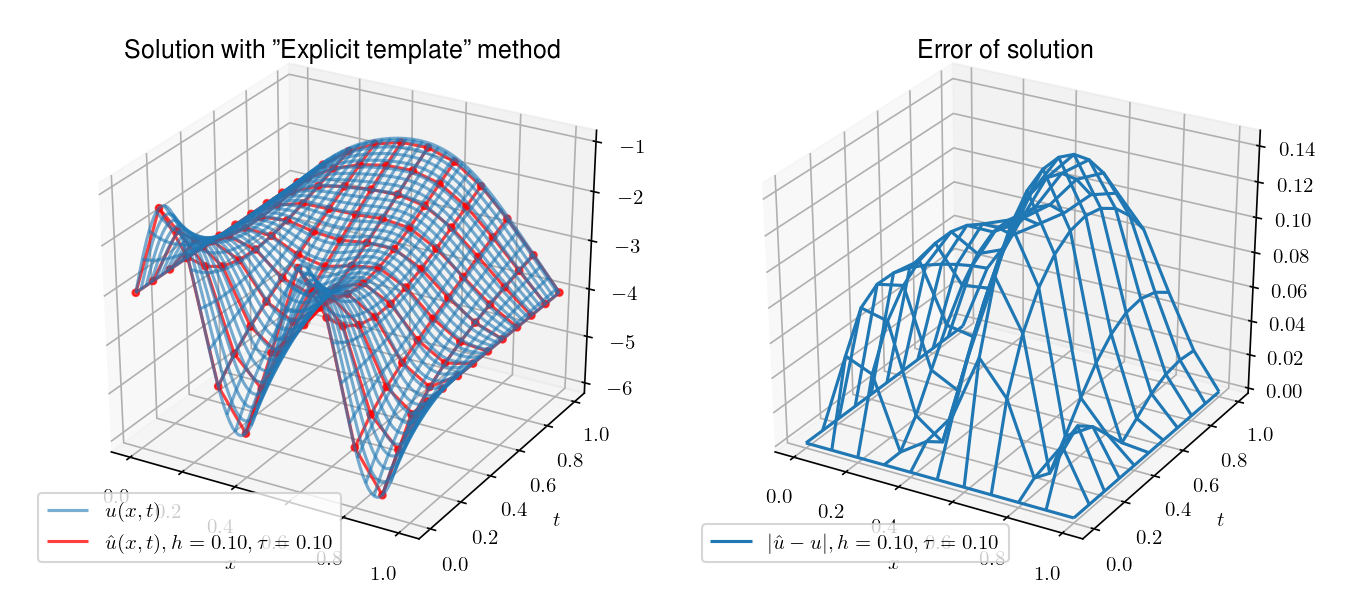

In [11]:
fig2 = plot_solution(uu_expl, xx, tt, u_true, 'Explicit template')

#### B. Неявная схема 

Шаблон: 

Аппроксимация производных: 

$$ \begin{align}
   &\frac{\partial u}{\partial t}\Bigg\rvert_{(x_i, t_k)}=\frac{u_i^{k+1}-u_i^k}{\tau}+O(\tau),\\
   &\frac{\partial^2 x}{\partial x^2}\Bigg\rvert_{(x_i ,t_k)}=\frac{u_{i-1}^{k+1} - 2u_i^{k+1} + u_{i+1}^{k+1}}{h^2}+O(h^2).
   \end{align}$$

Уравнения для значений функции в узлах следующего слоя (не забываем, что $u_0^{k+1}=\mu_1^{k+1}$, $u_n^{k+1}=\mu_2^{k+1}$): 

$$ \gamma u_{i-1}^{k+1} - (1+2\gamma)u_i^{k+1} + \gamma u_{i+1}^{k+1} = -u_i^k -\tau f_i^{k+1},\text{ }i\in\{1, ..., n-1\}.$$

В итоге значения на следующем слое взаимосвязаны  (отсюда неявность метода) и получаются путём решения трёхдиагональной СЛАУ. Она легко решается методом прогонки, которая устойчива ввиду диагонального преобладания в матрице системы. Заметим, что матрица системы неизменна от итерации к итерации, меяется лишь правая часть.

Схема абсолютно устойчива, порядок аппроксимации также $O(h^2 + \tau)$.

In [12]:
uu_impl = uu.copy()

# матрица системы в виде, пригодном для передачи параметром во
# встроенную функцию `solve_baned`, решающую СЛАУ методом прогонки
M = np.repeat(array([[gamma], [-(1+2*gamma)], [gamma]]), n-1, axis=1)
M[0, 0] = 0; M[-1, -1] = 0

for k in range(m):
    uk = uu_impl[k]; fk = ff[k]
    rhs = -uk[1:-1] - tau*fk[1:-1]
    rhs[0]  -= gamma * mu1(t[k+1])
    rhs[-1] -= gamma * mu2(t[k+1])
    uu_impl[k+1, 1:-1] = solve_banded((1, 1), M, rhs)

#uu_impl[::-1]

<IPython.core.display.Javascript object>


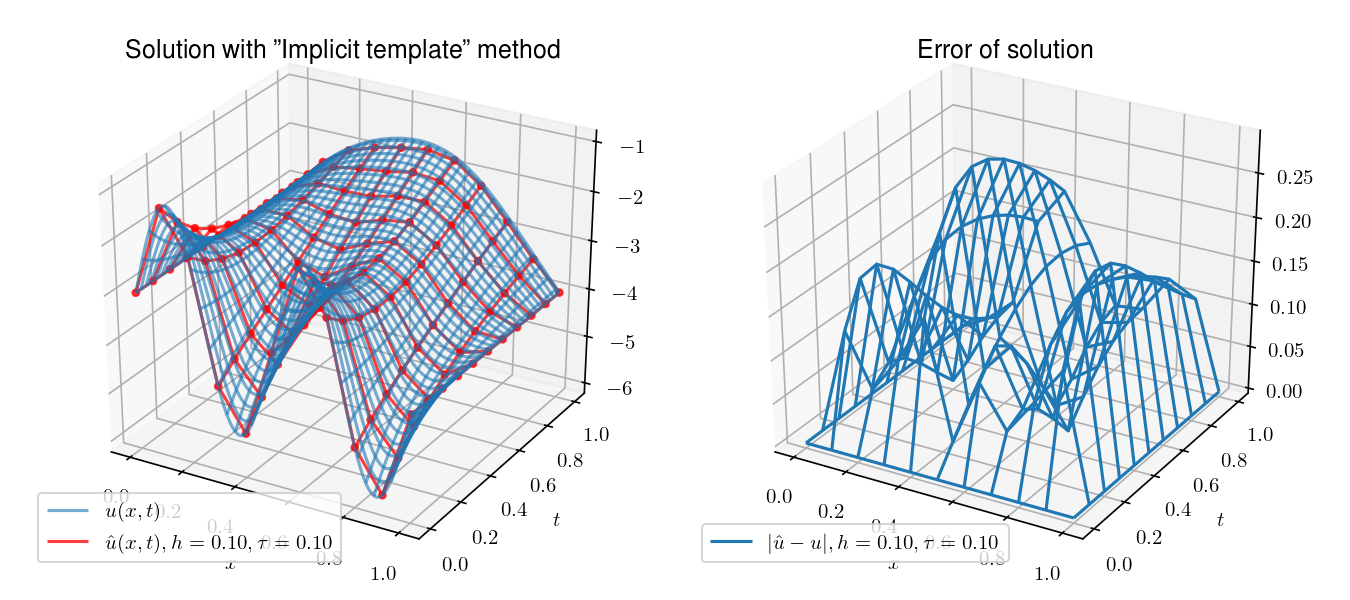

In [13]:
fig3 = plot_solution(uu_impl, xx, tt, u_true, 'Implicit template')

#### C. Схема Кранка-Николсон 

Шаблон:

Аппроксимация дифференциальных выражений:


Уравнение для значений слоя на следующем узле (вновь неявная схема, вновь СЛАУ, вновь прогонка):

$$\begin{align}
u_0^{k+1} &= \mu_1^{k+1},\\
\frac{\gamma}{2}u_{i-1}^{k+1} - (1+\gamma)u_i^{k+1} + \frac{\gamma}{2}u_{i+1}^{k+1} &= -\frac{\gamma}{2}u_{i-1}^k
-(1-\gamma)u_i^k - \frac{\gamma}{2}u_{i+1}^k - \frac{\tau}{2}(f_i^k + f_i^{k+1}), i\in\{1,...,n-1\},\\
u_n^{k+1} &= \mu_2^{k+1}.\end{align}
$$

Порядок аппроксимации уже $O(h^2+\tau^2)$, схема абсолютно устойчива.

In [14]:
uu_cn = uu.copy()

# матрица системы в виде, пригодном для передачи параметром во
# встроенную функцию `solve_baned`, решающую СЛАУ методом прогонки
M = np.repeat(array([[gamma/2], [-(1+gamma)], [gamma/2]]), n-1, axis=1)
M[0, 0] = 0; M[-1, -1] = 0

for k in range(m):
    uk = uu_cn[k]
    rhs = -(gamma/2*uk[:-2] + (1-gamma)*uk[1:-1] + gamma/2*uk[2:] + tau/2*(ff[k, 1:-1] + ff[k+1, 1:-1]))
    rhs[0]  -= gamma * mu1(t[k+1]) / 2
    rhs[-1] -= gamma * mu2(t[k+1]) / 2
    uu_cn[k+1, 1:-1] = solve_banded((1, 1), M, rhs)

#uu_cn[::-1]

<IPython.core.display.Javascript object>


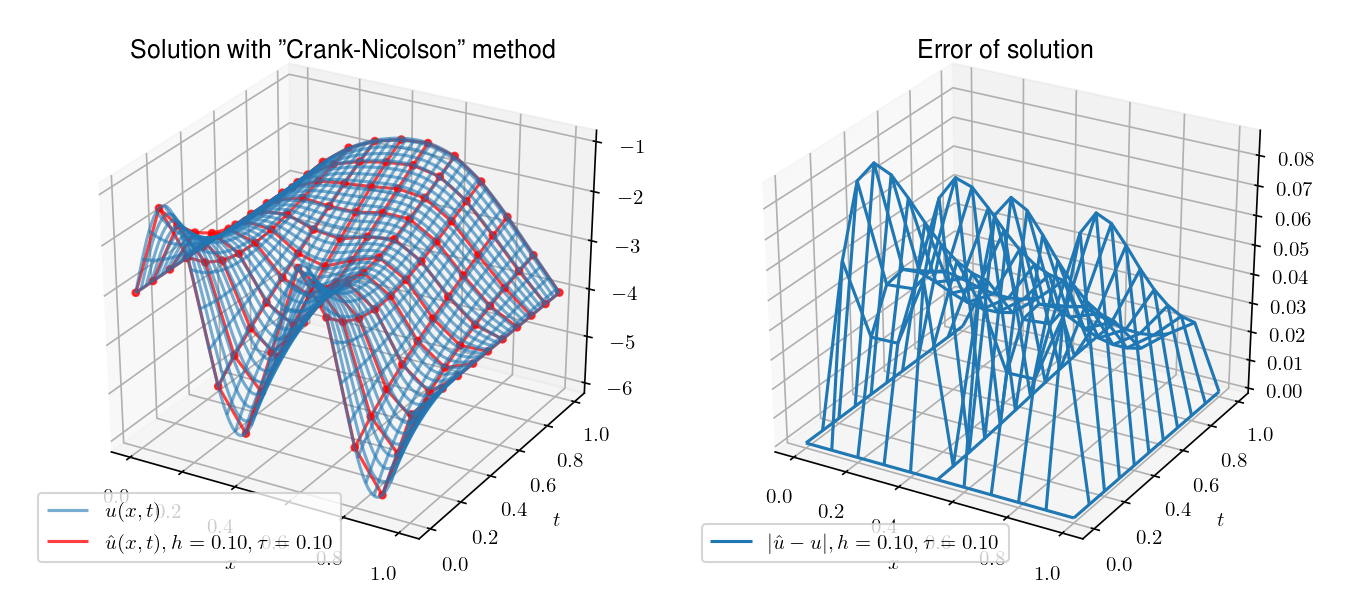

In [15]:
fig4 = plot_solution(uu_cn, xx, tt, u_true, 'Crank-Nicolson')

#### D. Немного о весовых схемах 

### Аппроксимация краевых условий 2-го и 3-го рода